In [225]:
import math
import random as rnd
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import clear_output,display, HTML
from time import sleep
import ipywidgets as widgets 
import networkx as nx
import numpy as np
from matplotlib.colors import ListedColormap
from scipy import stats, mean
dbug = True
plt.rcParams["figure.figsize"] = (16,8)  

In [226]:
class Agent:
    t_now = 0
    t_next = 1
    
    imp_pa = 0.0
    imp_ei = 0.0
    thr_pa = 0.0
    thr_ei = 0.0

    
    @staticmethod
    def tick():
        Agent.t_next,Agent.t_now = Agent.t_now, Agent.t_next
    
    
    def __init__(self,id,bw,ei=0,env=1.0):
        self.id = id
        self.bw = [bw,0.0]
        self.ei = [ei,0.0]
        self.pa = [(ei*0.9)/(0.083*bw+0.85),0]
        self.ee = 0
        self.links=[]
        self.number_of_links=0
        self.pa_i = 0.0
        self.ei_i = 0.0
        self.env = env
        
    def add_edge(self,agent):
        if agent != self:
            if agent not in self.links:
                self.links.append(agent)
                self.number_of_links+=1

    def pa_get(self):
        return self.pa[Agent.t_now]
    
    def pa_set(self,pa):
        self.pa[Agent.t_next] = pa

    def ei_get(self):
        return self.ei[Agent.t_now]
    
    def ei_set(self,ei):
        self.ei[Agent.t_next] = ei

    def bw_get(self):
        return self.bw[Agent.t_now]
    
    def bw_set(self,bw):
        self.bw[Agent.t_next] = bw    
        
    def update(self, influence=False):
        new_pa_part = 0
        new_ei_part = 0
        # a change in pa and ei is only triggered when influence flag is set
        if influence and self.number_of_links>0:
            pa_i_sum = 0
            ei_i_sum = 0
            ## sum up influence of links
            for a in self.links:
                pa_i_sum+= a.pa_get()-self.pa_get()
                ei_i_sum+= a.ei_get()-self.ei_get()
            self.pa_i = pa_i_sum/self.number_of_links
            self.ei_i = ei_i_sum/self.number_of_links

            # incorporate effect of environment
            if self.pa_i >= 0:
                pa_i_env = self.pa_i*self.env 
            else:
                pa_i_env = self.pa_i/self.env

            if self.ei_i >= 0:
                ei_i_env = self.ei_i/self.env 
            else:
                ei_i_env = self.ei_i*self.env

            # threshold and impact
            if pa_i_env>= Agent.thr_pa*self.pa_get():
                new_pa_part = (Agent.imp_pa*self.pa_get())
            if pa_i_env<= -(Agent.thr_pa*self.pa_get()):
                new_pa_part = -(Agent.imp_pa*self.pa_get())

            if ei_i_env>= Agent.thr_ei*self.ei_get():
                new_ei_part = (Agent.imp_ei*self.ei_get())
            if ei_i_env<= -(Agent.thr_ei*self.ei_get()):
                new_ei_part = -(Agent.imp_ei*self.ei_get())

                
        new_pa = self.pa_get()+new_pa_part
        new_ei = self.ei_get()+new_ei_part
        self.pa_set(new_pa)
        self.ei_set(new_ei)
        
        # new energy expenditure
        self.ee = new_pa * (0.083 * self.bw_get() + 0.85) + (0.1 * new_ei)
        delta_e = new_ei-self.ee
        
        # new bw
        self.bw_set(self.bw_get()+delta_e/32.2)
        
        
        
        

In [227]:

data_file = open("BW.csv")
bw_data_2009=np.array([ float(x) for x in data_file ]) 
data_file = open("EI.csv")
ei_data_2009=np.array([ float(x) for x in data_file ]) 
data_file = open("Change_BW.csv")
bw_data_2011=np.array([ float(x) for x in data_file ]) 
t_stat, p_val = stats.ttest_ind(data_2009,data_2011, equal_var=True)

print("Number of agents:",len(bw_data_2009))
lab = "Mean bw_2009:{:.2f}kg  Stdv {:.4f} Mean bw_2011:{:.2f}kg  p:{:.4f}"
print(lab.format(bw_data_2009.mean(),bw_data_2009.std(),bw_data_2011.mean(),p_val))
lab = "Mean ei_2009:{:.2f} Stdv {:.4f}"
print(lab.format(ei_data_2009.mean(),ei_data_2009.std()))


Number of agents: 2197
Mean bw_2009:61.73kg  Stdv 11.2576 Mean bw_2011:62.51kg  p:0.0198
Mean ei_2009:8.51 Stdv 1.2805


In [228]:
def init(number_of_links = 3):
    agents= [Agent(i,bw_data_2009[i],ei=ei_data_2009[i]) for i in range(len(data_2009))]
    network = nx.erdos_renyi_graph(len(agents),number_of_links/len(agents))
    edges = list(network.edges())
    for edge in edges:
        a1 = agents[edge[0]]
        a2 = agents[edge[1]]
        a1.add_edge(a2)
        a2.add_edge(a1)
        
    # get largest component
    gcc = sorted(nx.connected_components(network), key=len, reverse=True)
    g0 = network.subgraph(gcc[0])

    #get degree distribution
    degree = dict(network.degree())
    values = np.array([ value for k,value in degree.items()])
    color = ["red" if len(a.links)==0 else "lightblue" for a in agents]
    number_single = color.count("red")
    plt.subplot(1,2,1)
    pos = nx.random_layout(network)
    nx.draw_networkx(network, pos=pos,node_color = color,with_labels=False,alpha=0.5, node_size=12,width=0.1,font_size=8) 
    plt.subplot(1,2,2)
    plt.ylabel("number of agents")
    plt.xlabel("degree")
    plt.hist(values)
    plt.show()
    label = "Mean degree: {:.2f} Number of clusters: {} Single nodes: {} "
    print(label.format(values.mean(),len(gcc),number_single))
    print("Largest component size:",len(gcc[0]))
    # for i, g in enumerate(gcc):
    #     label = "Cluster: {}  size:{}"
    #     print(label.format(i,len(g)))   
    return agents

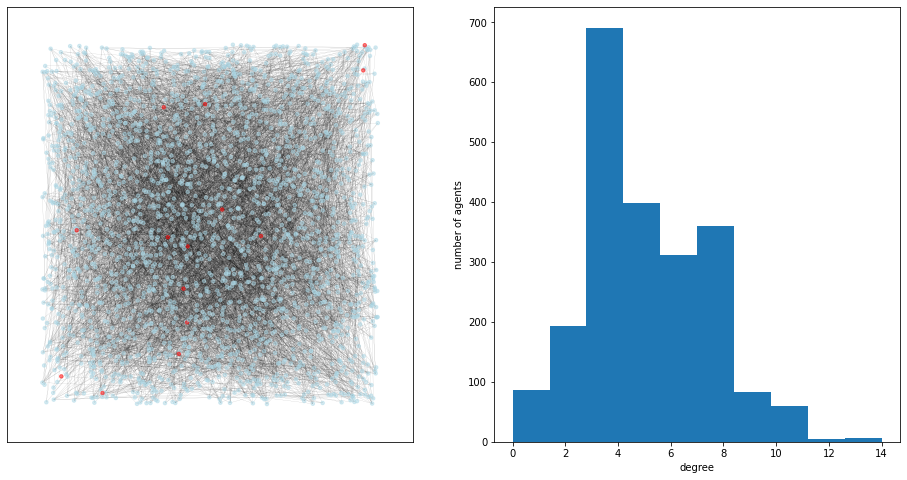

Mean degree: 4.99 Number of clusters: 15 Single nodes: 14 
Largest component size: 2183
Mean pa: 61.73  stdev: 11.26
Mean pa: 61.34  stdev: 5.72


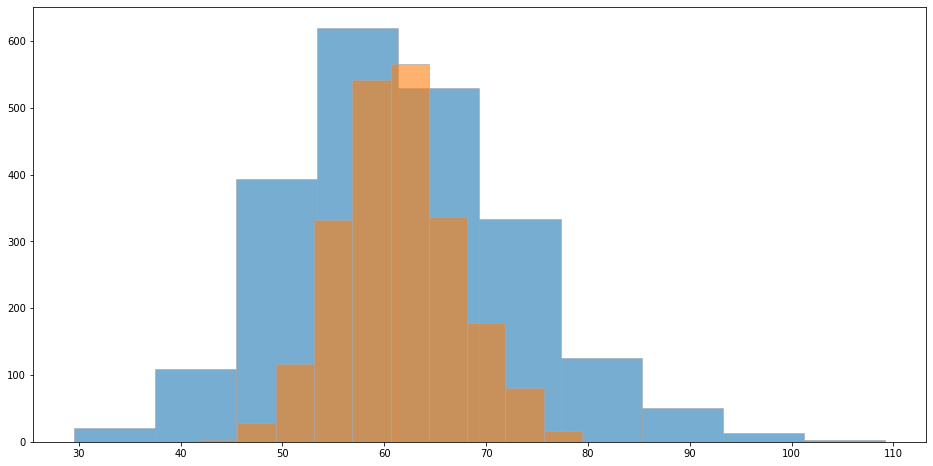

In [231]:
agents = init(5)
Agent.imp_pa = 0.01
Agent.imp_ei = 0.01
Agent.thr_pa = 0.065
Agent.thr_ei = 0.065
bw_2009 = np.array([a.bw_get() for a in agents]) 
label = "Mean pa: {:.2f}  stdev: {:.2f}"
print(label.format(bw_2009.mean(),bw_2009.std()))
for t in range (2*365):
    flag = (t%7==0)
    for a in agents:
        a.update(flag)
    Agent.tick()
bw_2011 = np.array([a.bw_get() for a in agents]) 
label = "Mean pa: {:.2f}  stdev: {:.2f}"
print(label.format(bw_2011.mean(),bw_2011.std()))
plt.hist(bw_2009,alpha=0.6,edgecolor="darkgray")
plt.hist(bw_2011,alpha=0.6,edgecolor="darkgray")
plt.show()
